In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [2]:
%cd /kaggle/input/brain-tumor-mri-dataset


/kaggle/input/brain-tumor-mri-dataset


In [3]:
!ls

Testing  Training


In [14]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tf =transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [20]:
train_dl = DataLoader(
    datasets.ImageFolder("./Training", transform=tf),
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_dl = DataLoader(
    datasets.ImageFolder("./Testing", transform=tf),
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(256, 4)
).to(device)



In [17]:
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [21]:
model.train()
for epoch in range(10):
    running_loss = 0
    for x, y in train_dl:
        opt.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        running_loss += loss
        opt.step()
    print(f"Epoch {epoch+1} loss {running_loss}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1 loss 122.4052734375
Epoch 2 loss 68.05724334716797
Epoch 3 loss 47.51898956298828
Epoch 4 loss 34.52088165283203
Epoch 5 loss 25.570735931396484
Epoch 6 loss 17.85413932800293
Epoch 7 loss 13.622082710266113
Epoch 8 loss 11.692748069763184
Epoch 9 loss 9.032915115356445
Epoch 10 loss 6.561944961547852


In [22]:
from math import log
model.eval()
test_loss, correct = 0.0, 0
with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        test_loss += loss_fn(logits, y).item()*y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

test_loss /= len(test_dl.dataset)
accuracy = 100*correct/len(test_dl.dataset)
print(f"Test loss {test_loss}, accuracy {accuracy}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test loss 0.07991840530394326, accuracy 97.7116704805492


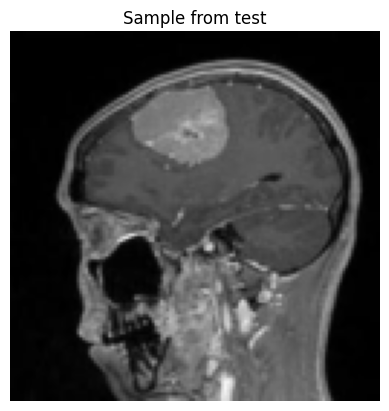

Predicted class meningioma, actual class meningioma


In [26]:
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model.eval()
idx = random.randrange(len(test_dl.dataset))
img, label = test_dl.dataset[idx]
unnorm = img * 0.5 + 0.5
plt.imshow(to_pil_image(unnorm))
plt.axis("off")
plt.title("Sample from test")
plt.show()

with torch.no_grad():
  logit = model(img.unsqueeze(0).to(device))
  pred = logit.argmax(dim=1).item()
  #print(f"Predicted class {pred}, actual class {label}")
classes_name = test_dl.dataset.classes
print(f"Predicted class {classes_name[pred]}, actual class {classes_name[label]}")